<a href="https://colab.research.google.com/github/AlfonsoRafel/Posgrado-IA---UBA/blob/master/09.%20Natural%20Language%20Processing/Trabajo_Final_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio Clase 6 - NLP

Fuentes: 
* **https://colab.research.google.com/drive/1jzsUGUlXob73ozBN1PghUYLCvXYpsQ0H**
* https://keras.io/examples/nlp/text_classification_from_scratch/
* https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

## 1. Descargar el dataset del siguiente link.

In [ ]:
%%capture 
!pip install funpymodeling
!pip install h5py
import nltk     
nltk.download('stopwords')
nltk.download('punkt')
from funpymodeling.exploratory import freq_tbl, status, profiling_num, cat_vars, num_vars, corr_pair
from funpymodeling.data_prep import todf
!pip install ipython-autotime
%load_ext autotime

time: 817 µs (started: 2020-12-31 23:14:05 +00:00)


In [ ]:
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
from google.colab.data_table import DataTable
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import string
import bs4
import timeit
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json

time: 1.67 s (started: 2020-12-31 23:14:05 +00:00)


In [ ]:
import multiprocessing
from gensim.models import Word2Vec

time: 257 ms (started: 2020-12-31 23:14:07 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 20.6 s (started: 2020-12-31 23:14:07 +00:00)


In [ ]:
def save_model(model, name='model'):
  model_path = "/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP/" + str(name)
  # serialize model to JSON
  model_json = model.to_json()
  with open(model_path + ".json", "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(model_path + ".h5")
  print("Saved model to disk")
  return "Saved"
 
def load_model(name='model'):
  model_path = "/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP/" + str(name)
  # load json and create model
  json_file = open(model_path + ".json", 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights(model_path + ".h5")
  return loaded_model

time: 14.6 ms (started: 2020-12-31 23:14:28 +00:00)


## 2. Pre-procesar el texto de manera básica:

Cargar el archivo

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


time: 3.36 s (started: 2020-12-31 23:14:28 +00:00)


In [ ]:
df.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

time: 4.26 ms (started: 2020-12-31 23:14:31 +00:00)


In [ ]:
df.sentiment = df.sentiment.map(lambda x: 1 if x == 'positive' else 0 )
reviews = df.review
sentiments = df.sentiment

time: 25.8 ms (started: 2020-12-31 23:14:31 +00:00)


* a. Eliminar tags html: por ejemplo <br />
* b. Eliminar puntuaciones
* c. Eliminar stopwords

Preprocesamiento con ciclo for:

In [ ]:
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

reviews=[]
for _, row in df[:None].iterrows():
    # Eliminar Tags
    words = text_to_word_sequence(row[0])
    words =[w.replace('br', ' ') for w in words]
    # Eliminar puntuaciones
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in words]
    # Eliminar stopwords
    tokens_without_sw = [word for word in stripped if not word in stopwords.words('english')] 
    reviews.append(tokens_without_sw)
  

time: 17min 3s


Preprocesamiento con map:

In [ ]:
# Remove html tags with Bs4
reviews = reviews.map(lambda text: bs4.BeautifulSoup(text, 'html.parser').get_text())

# Remove punctuation
reviews = reviews.map(lambda text:"".join([i for i in text if i not in string.punctuation]))

# Tokenize
reviews = reviews.map(lambda text: nltk.tokenize.word_tokenize(text))

# Remove Stopwords
reviews = reviews.map(lambda text: [i.lower() for i in text if i not in stopwords.words('english')])

In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP'

with open(PICKLE_PATH+'/IMDB_variables', 'wb') as f:
    pickle.dump(reviews, f)

time: 2.44 s


In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP'

with open(PICKLE_PATH+'/IMDB_variables', 'rb') as f:
    reviews = pickle.load(f)

time: 2.17 s (started: 2020-12-31 23:14:31 +00:00)


## 3. Entrenar un clasificador utilizando BOW.

* a. Definir el tamaño del vocabulario.
* b. (opcional) Agregar pesos utilizando TFIDF.
* c. Transformar los textos en vectores.

In [ ]:
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=5, window=2, size=300, negative=20, workers=cores-1, sg=0) 
w2v_model.build_vocab(reviews, progress_per=10000)

time: 9.22 s (started: 2020-12-29 13:49:03 +00:00)


In [ ]:
print('Tamaño del vocabulario: ', len(w2v_model.wv.vocab))
print('\n')

Tamaño del vocabulario:  41104


time: 3.23 ms (started: 2020-12-29 13:49:17 +00:00)


In [ ]:
w2v_model.train(reviews, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)

(29141971, 31561835)

time: 4min 7s (started: 2020-12-29 13:49:23 +00:00)


In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP'

with open(PICKLE_PATH+'/CBOW_model', 'wb') as f:
    pickle.dump(w2v_model, f)

time: 510 ms (started: 2020-12-29 14:00:08 +00:00)


In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP'

with open(PICKLE_PATH+'/CBOW_model', 'rb') as f:
    w2v_model = pickle.load(f)

time: 2.06 s (started: 2020-12-31 23:14:38 +00:00)


Generación de las features 

In [ ]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

time: 3.78 ms (started: 2020-12-31 22:29:08 +00:00)


In [ ]:
# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

time: 3.02 ms (started: 2020-12-31 22:29:08 +00:00)


In [ ]:
#clean_train_reviews = []
#for review in train['review']:
#    clean_train_reviews.append(review_wordlist(review, remove_stopwords=True))
    
trainDataVecs = getAvgFeatureVecs(reviews, w2v_model, 300)

Review 0 of 50000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Review 1000 of 50000
Review 2000 of 50000
Review 3000 of 50000
Review 4000 of 50000
Review 5000 of 50000
Review 6000 of 50000
Review 7000 of 50000
Review 8000 of 50000
Review 9000 of 50000
Review 10000 of 50000
Review 11000 of 50000
Review 12000 of 50000
Review 13000 of 50000
Review 14000 of 50000
Review 15000 of 50000
Review 16000 of 50000
Review 17000 of 50000
Review 18000 of 50000
Review 19000 of 50000
Review 20000 of 50000
Review 21000 of 50000
Review 22000 of 50000
Review 23000 of 50000
Review 24000 of 50000
Review 25000 of 50000
Review 26000 of 50000
Review 27000 of 50000
Review 28000 of 50000
Review 29000 of 50000
Review 30000 of 50000
Review 31000 of 50000
Review 32000 of 50000
Review 33000 of 50000
Review 34000 of 50000
Review 35000 of 50000
Review 36000 of 50000
Review 37000 of 50000
Review 38000 of 50000
Review 39000 of 50000
Review 40000 of 50000
Review 41000 of 50000
Review 42000 of 50000
Review 43000 of 50000
Review 44000 of 50000
Review 45000 of 50000
Review 46000 of 500

In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP'

with open(PICKLE_PATH+'/CBOW_features', 'wb') as f:
    pickle.dump(trainDataVecs, f)

time: 221 ms (started: 2020-12-29 14:02:59 +00:00)


In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP'

with open(PICKLE_PATH+'/CBOW_features', 'rb') as f:
    trainDataVecs = pickle.load(f)

time: 1.14 s (started: 2020-12-31 23:14:44 +00:00)


d. Crear los datasets de train, validation y test.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(trainDataVecs, sentiments, test_size=0.2)

time: 28.2 ms (started: 2020-12-31 23:14:47 +00:00)


e. (opcional) Aplicar PCA para reducir la dimensión de los vectores.

f. Entrenar una red neuronal (seleccionar arquitectura, loss y optimizador).

In [ ]:
def plot_history(model_history):

  train_accuracy = model_history.history['AUC']
  train_loss = model_history.history['loss']

  fig, (a1, a2) = plt.subplots(1,2, figsize=(20,10))

  a1.set_title('AUC evolution', fontsize=20)
  a1.plot(train_accuracy, label='Train_AUC')
  a1.legend()

  a2.set_title('Loss evolution', fontsize=20)
  a2.plot(train_loss, label='Train_loss')
  a2.legend()

  plt.show()

  return

time: 5.5 ms (started: 2020-12-31 22:29:16 +00:00)


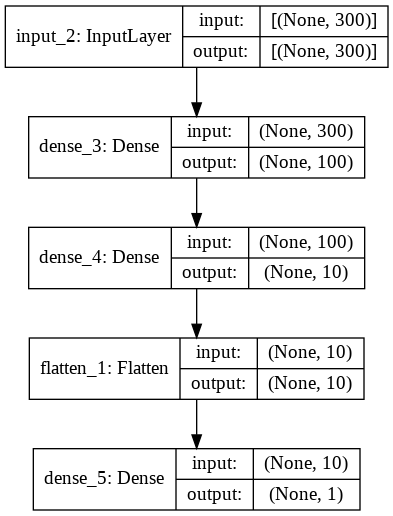

time: 268 ms (started: 2020-12-31 23:18:38 +00:00)


In [ ]:
# Pruebo usando como input el Bag of words de las palabras pasadas a sequencias.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Flatten, LSTM
from tensorflow.keras.utils import plot_model

embedding_dim = 64

sequential_model = Sequential()

sequential_model.add(Input(shape=(x_train.shape[1],)))
sequential_model.add(Dense(100, activation='relu'))
sequential_model.add(Dense(10, activation='relu'))
sequential_model.add(Flatten())
sequential_model.add(Dense(1, activation='sigmoid'))

sequential_model.compile(loss='binary_crossentropy', 
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics = ['AUC'])

plot_model(sequential_model, show_shapes=True)

In [ ]:
history_sequential = sequential_model.fit(x = x_train, 
                                          y = y_train,
                                          epochs=10,
                                          batch_size=100,
                                          shuffle = True,
                                          validation_split=0.05)

Epoch 1/10
380/380 [==============================] - 4s 4ms/step - loss: 0.4912 - auc: 0.8428 - val_loss: 0.3422 - val_auc: 0.9297
Epoch 2/10
380/380 [==============================] - 1s 3ms/step - loss: 0.3317 - auc: 0.9324 - val_loss: 0.3480 - val_auc: 0.9304
Epoch 3/10
380/380 [==============================] - 1s 3ms/step - loss: 0.3279 - auc: 0.9338 - val_loss: 0.3221 - val_auc: 0.9371
Epoch 4/10
380/380 [==============================] - 1s 3ms/step - loss: 0.3200 - auc: 0.9372 - val_loss: 0.3259 - val_auc: 0.9366
Epoch 5/10
380/380 [==============================] - 1s 3ms/step - loss: 0.3148 - auc: 0.9392 - val_loss: 0.3140 - val_auc: 0.9396
Epoch 6/10
380/380 [==============================] - 1s 3ms/step - loss: 0.3104 - auc: 0.9407 - val_loss: 0.3272 - val_auc: 0.9399
Epoch 7/10
380/380 [==============================] - 1s 3ms/step - loss: 0.3047 - auc: 0.9429 - val_loss: 0.3202 - val_auc: 0.9404
Epoch 8/10
380/380 [==============================] - 1s 3ms/step - loss: 0.

In [ ]:
sequential_model_pred = sequential_model.predict(x_test)

time: 1.93 s (started: 2020-12-31 23:15:05 +00:00)


In [ ]:
save_model(sequential_model, name='sequential_model')

Saved model to disk


'Saved'

time: 441 ms (started: 2020-12-31 22:29:36 +00:00)


In [ ]:
sequential_model = load_model(name='sequential_model')

time: 5.85 s (started: 2020-12-31 23:14:59 +00:00)


g. Medir AUC.

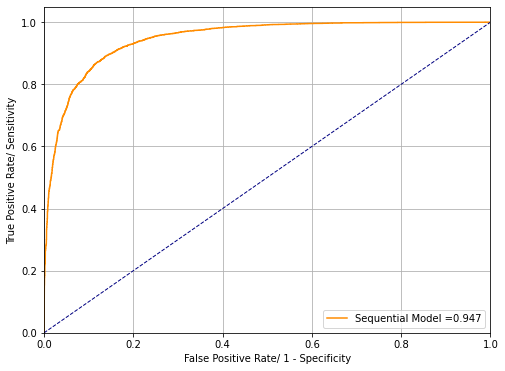

time: 173 ms (started: 2020-12-31 23:15:09 +00:00)


In [ ]:
# Comparar los resultados obtenidos
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc


plt.figure(figsize=(8, 6))
plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y_test, sequential_model_pred)
plt.plot(fpr, tpr, color='darkorange',
         label='Sequential Model ={0:.3f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate/ 1 - Specificity')
plt.ylabel('True Positive Rate/ Sensitivity')
plt.show()

## 4. Entrenar un clasificador utilizando words embeddings (probar con GloVe y con FastText).

Cargar los Embeddings de Glove y Fasttext

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-twitter-25')
fsttxt = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP'

with open(PICKLE_PATH+'/glove_vectors', 'wb') as f:
    pickle.dump(glove_vectors, f)

In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP'

with open(PICKLE_PATH+'/fstext_vectors', 'wb') as f:
    pickle.dump(fsttxt, f)

time: 12.1 s (started: 2020-12-29 14:17:57 +00:00)


In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP'

with open(PICKLE_PATH+'/glove_vectors', 'rb') as f:
    glove_vectors = pickle.load(f)

time: 5.63 s (started: 2020-12-31 23:15:16 +00:00)


In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP'

with open(PICKLE_PATH+'/fstext_vectors', 'rb') as f:
    fsttxt = pickle.load(f)

time: 14.8 s (started: 2020-12-31 23:15:22 +00:00)


a. Calcular el embedding de cada texto como el promedio de los embeddings
de las palabras.

In [ ]:
trainDataVecs_glove = getAvgFeatureVecs(reviews[:3000], glove_vectors, 25)

Review 0 of 3000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Review 1000 of 3000
Review 2000 of 3000
time: 7min 19s (started: 2020-12-29 14:19:33 +00:00)


In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP'

with open(PICKLE_PATH+'/Glove_features', 'wb') as f:
    pickle.dump(trainDataVecs_glove, f)

time: 10.3 ms (started: 2020-12-29 14:26:52 +00:00)


In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP'

with open(PICKLE_PATH+'/Glove_features', 'rb') as f:
    trainDataVecs_glove = pickle.load(f)

time: 269 ms (started: 2020-12-31 23:15:36 +00:00)


In [ ]:
trainDataVecs_fstext = getAvgFeatureVecs(reviews[:3000], fsttxt, 300)

Review 0 of 3000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Review 1000 of 3000
Review 2000 of 3000
time: 6min 16s (started: 2020-12-29 14:26:52 +00:00)


In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP'

with open(PICKLE_PATH+'/Fasttext_features', 'wb') as f:
    pickle.dump(trainDataVecs_fstext, f)

time: 18.4 ms (started: 2020-12-29 14:33:09 +00:00)


In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP'

with open(PICKLE_PATH+'/Fasttext_features', 'rb') as f:
    trainDataVecs_fstext = pickle.load(f)

time: 267 ms (started: 2020-12-31 23:15:37 +00:00)


b. Crear los datasets de train, validation y test.

In [ ]:
from sklearn.model_selection import train_test_split

x_train_glove, x_test_glove, y_train_glove, y_test_glove = train_test_split(trainDataVecs_glove, sentiments.loc[:2999][:], test_size=0.2)

time: 3.65 ms (started: 2020-12-31 23:15:37 +00:00)


In [ ]:
x_train_fast, x_test_fast, y_train_fast, y_test_fast = train_test_split(trainDataVecs_fstext, sentiments.loc[:2999][:], test_size=0.2)

time: 5.04 ms (started: 2020-12-31 23:15:37 +00:00)


c. Entrenar una red neuronal (seleccionar arquitectura, loss y optimizador).

In [ ]:
# Pruebo usando como input el Bag of words de las palabras pasadas a sequencias.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Flatten, LSTM
from tensorflow.keras.utils import plot_model

def create_model(x_train):
  embedding_dim = 64
  sequential_model = Sequential()
  sequential_model.add(Input(shape=(x_train.shape[1],))) 
  sequential_model.add(Dense(100, activation='relu'))
  sequential_model.add(Dense(10, activation='relu'))
  sequential_model.add(Flatten())
  sequential_model.add(Dense(1, activation='sigmoid'))
  sequential_model.compile(loss='binary_crossentropy', 
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics = ['AUC'])
  plot_model(sequential_model, show_shapes=True)
  return sequential_model

time: 32.9 ms (started: 2020-12-31 22:29:58 +00:00)


In [ ]:
model_glove = create_model(x_train_glove)
history_sequential = model_glove.fit(x = x_train_glove, 
                                          y = y_train_glove,
                                          epochs=50,
                                          batch_size=100,
                                          shuffle = True,
                                          validation_split=0.05)

Epoch 1/50
23/23 [==============================] - 1s 14ms/step - loss: 0.6975 - auc: 0.4979 - val_loss: 0.6718 - val_auc: 0.7894
Epoch 2/50
23/23 [==============================] - 0s 5ms/step - loss: 0.6707 - auc: 0.6793 - val_loss: 0.6327 - val_auc: 0.8133
Epoch 3/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6453 - auc: 0.7283 - val_loss: 0.6025 - val_auc: 0.8289
Epoch 4/50
23/23 [==============================] - 0s 4ms/step - loss: 0.6183 - auc: 0.7607 - val_loss: 0.5675 - val_auc: 0.8406
Epoch 5/50
23/23 [==============================] - 0s 5ms/step - loss: 0.6026 - auc: 0.7643 - val_loss: 0.5390 - val_auc: 0.8498
Epoch 6/50
23/23 [==============================] - 0s 4ms/step - loss: 0.5760 - auc: 0.7885 - val_loss: 0.5183 - val_auc: 0.8586
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 0.5755 - auc: 0.7794 - val_loss: 0.5259 - val_auc: 0.8674
Epoch 8/50
23/23 [==============================] - 0s 4ms/step - loss: 0.5593 - auc: 0.7

In [ ]:
model_fast = create_model(x_train_fast)
history_sequential = model_fast.fit(x = x_train_fast, 
                                          y = y_train_fast,
                                          epochs=50,
                                          batch_size=100,
                                          shuffle = True,
                                          validation_split=0.05)

Epoch 1/50
23/23 [==============================] - 1s 14ms/step - loss: 0.6909 - auc: 0.6052 - val_loss: 0.6812 - val_auc: 0.7921
Epoch 2/50
23/23 [==============================] - 0s 5ms/step - loss: 0.6792 - auc: 0.7988 - val_loss: 0.6627 - val_auc: 0.8306
Epoch 3/50
23/23 [==============================] - 0s 5ms/step - loss: 0.6619 - auc: 0.7955 - val_loss: 0.6322 - val_auc: 0.8363
Epoch 4/50
23/23 [==============================] - 0s 5ms/step - loss: 0.6330 - auc: 0.8318 - val_loss: 0.6046 - val_auc: 0.8432
Epoch 5/50
23/23 [==============================] - 0s 5ms/step - loss: 0.5922 - auc: 0.8502 - val_loss: 0.5680 - val_auc: 0.8524
Epoch 6/50
23/23 [==============================] - 0s 4ms/step - loss: 0.5454 - auc: 0.8673 - val_loss: 0.5263 - val_auc: 0.8602
Epoch 7/50
23/23 [==============================] - 0s 5ms/step - loss: 0.5083 - auc: 0.8695 - val_loss: 0.5120 - val_auc: 0.8614
Epoch 8/50
23/23 [==============================] - 0s 5ms/step - loss: 0.4827 - auc: 0.8

In [ ]:
model_glove_pred = model_glove.predict(x_test_glove)
model_fast_pred = model_fast.predict(x_test_fast)

time: 167 ms (started: 2020-12-31 23:15:58 +00:00)


d. Medir AUC.

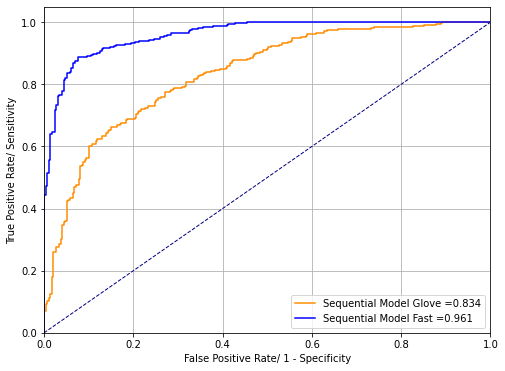

time: 174 ms (started: 2020-12-31 23:16:01 +00:00)


In [ ]:
# Comparar los resultados obtenidos
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc


plt.figure(figsize=(8, 6))
plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y_test_glove, model_glove_pred)
plt.plot(fpr, tpr, color='darkorange',
         label='Sequential Model Glove ={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test_fast, model_fast_pred)
plt.plot(fpr, tpr, color='blue',
         label='Sequential Model Fast ={0:.3f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate/ 1 - Specificity')
plt.ylabel('True Positive Rate/ Sensitivity')
plt.show()

In [ ]:
save_model(model_glove, name='model_glove')
save_model(model_fast, name='model_fast')

Saved model to disk
Saved model to disk


'Saved'

time: 858 ms (started: 2020-12-29 14:35:54 +00:00)


In [ ]:
model_glove = load_model(name='model_glove')
model_fast = load_model(name='model_fast')

time: 969 ms (started: 2020-12-31 23:15:53 +00:00)


e. Tratar de mejorar los embeddings de los textos con:
* i. Agregar TFIDF como pesos a las palabras.
* ii. En lugar de tomar el promedio probar tomando el max o el min de
cada componente de los embeddings de las palabras.
* iii. Probar diferentes tamaños de embeddings.

## 5. Entrenar un clasificador utilizando celdas LSTM.

a. Convertir secuencias de palabras a secuencias de números (indexer).

In [ ]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

time: 1.65 ms (started: 2020-12-31 23:17:46 +00:00)


In [ ]:
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

time: 1.01 ms (started: 2020-12-31 23:17:46 +00:00)


In [ ]:
from sklearn.model_selection import train_test_split

x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm = train_test_split(reviews, sentiments, test_size=0.2)

time: 20.6 ms (started: 2020-12-31 23:17:48 +00:00)


In [ ]:
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train_lstm)
x_train_lstm = token.texts_to_sequences(x_train_lstm)
x_test_lstm = token.texts_to_sequences(x_test_lstm)

# max_length = get_max_length()
max_length=80

time: 4.83 s (started: 2020-12-31 23:17:49 +00:00)


b. Agregar padding para que cada elemento de entrenamiento tenga la
misma longitud.

In [ ]:
x_train_lstm = pad_sequences(x_train_lstm, maxlen=max_length, padding='post', truncating='post')
x_test_lstm = pad_sequences(x_test_lstm, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

time: 491 ms (started: 2020-12-31 23:17:54 +00:00)


c. Armar una red LSTM con las siguientes capas:
* i. Capa de embedding que transforma un número (index) en un
embedding.
* ii. Agregar uno dos layers LSTM para obtener el embedding de la
secuencias.
* iii. Agregar un layer denso para entrenar el clasificador.

In [ ]:
EMBED_DIM = 300
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 300)           30109500  
_________________________________________________________________
lstm (LSTM)                  (None, 80, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 80, 64)            49408     
_________________________________________________________________
dense_6 (Dense)              (None, 80, 1)             65        
Total params: 30,378,621
Trainable params: 30,378,621
Non-trainable params: 0
_________________________________________________________________
None
time: 715 ms (started: 2020-12-31 23:18:44 +00:00)


In [ ]:
model.fit(x_train_lstm, y_train_lstm, batch_size = 128, epochs = 5)

Epoch 1/5
313/313 [==============================] - 93s 290ms/step - loss: 0.5143 - accuracy: 0.7302
Epoch 2/5
313/313 [==============================] - 90s 288ms/step - loss: 0.2907 - accuracy: 0.8747
Epoch 3/5
313/313 [==============================] - 90s 287ms/step - loss: 0.2084 - accuracy: 0.9093
Epoch 4/5
313/313 [==============================] - 90s 287ms/step - loss: 0.1630 - accuracy: 0.9267
Epoch 5/5
313/313 [==============================] - 90s 286ms/step - loss: 0.1308 - accuracy: 0.9402


time: 7min 32s (started: 2020-12-31 23:18:46 +00:00)


In [ ]:
save_model(model, name='model_lstm')

Saved model to disk


'Saved'

time: 503 ms (started: 2020-12-31 23:26:19 +00:00)


In [ ]:
model = load_model(name='model_lstm')

time: 1.23 s (started: 2020-12-31 23:27:41 +00:00)


In [ ]:
lstm_pred = model.predict(x_test_lstm)

time: 2.15 s (started: 2020-12-31 23:27:43 +00:00)


In [ ]:
lstm_pred = lstm_pred[:, lstm_pred.shape[1] - 1, :]

time: 1.89 ms (started: 2020-12-31 23:27:45 +00:00)


e. LSTM con embeddings preentrenados

In [ ]:
from sklearn.model_selection import train_test_split

x_train_lstm_pre, x_test_lstm_pre, y_train_lstm_pre, y_test_lstm_pre = train_test_split(reviews, sentiments, test_size=0.2)

time: 41.5 ms (started: 2020-12-31 23:27:48 +00:00)


In [ ]:
token = Tokenizer()    
token.fit_on_texts(x_train_lstm_pre)
x_train_lstm_pre = token.texts_to_sequences(x_train_lstm_pre)
x_test_lstm_pre = token.texts_to_sequences(x_test_lstm_pre)

word_index = token.word_index
# max_length = get_max_length()
max_length = 80
EMBED_DIM = 25

time: 5.26 s (started: 2020-12-31 23:27:49 +00:00)


In [ ]:
x_train_lstm_pre = pad_sequences(x_train_lstm_pre, maxlen=max_length, padding='post', truncating='post')
x_test_lstm_pre = pad_sequences(x_test_lstm_pre, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

time: 457 ms (started: 2020-12-31 23:27:54 +00:00)


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_DIM))
for word, i in word_index.items():
    try:
      embedding_vector = glove_vectors[word]
      if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    except:
        embedding_matrix[i] = np.zeros(EMBED_DIM)

time: 331 ms (started: 2020-12-31 23:27:55 +00:00)


In [ ]:
model_pretrained = Sequential()
model_pretrained.add(Embedding(len(word_index) + 1, EMBED_DIM, weights=[embedding_matrix], input_length=max_length, trainable=False))
model_pretrained.add(LSTM(128, return_sequences=True))
model_pretrained.add(LSTM(64, return_sequences=True))
model_pretrained.add(Dense(1, activation='sigmoid'))
model_pretrained.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model_pretrained.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 25)            2516000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 80, 128)           78848     
_________________________________________________________________
lstm_3 (LSTM)                (None, 80, 64)            49408     
_________________________________________________________________
dense_7 (Dense)              (None, 80, 1)             65        
Total params: 2,644,321
Trainable params: 128,321
Non-trainable params: 2,516,000
_________________________________________________________________
None
time: 476 ms (started: 2020-12-31 23:27:55 +00:00)


In [ ]:
model_pretrained.fit(x_train_lstm_pre, y_train_lstm_pre, batch_size = 128, epochs = 5)

Epoch 1/5
313/313 [==============================] - 6s 11ms/step - loss: 0.6191 - accuracy: 0.6500
Epoch 2/5
313/313 [==============================] - 3s 11ms/step - loss: 0.5560 - accuracy: 0.7087
Epoch 3/5
313/313 [==============================] - 3s 11ms/step - loss: 0.5270 - accuracy: 0.7287
Epoch 4/5
313/313 [==============================] - 3s 11ms/step - loss: 0.5129 - accuracy: 0.7360
Epoch 5/5
313/313 [==============================] - 3s 11ms/step - loss: 0.5003 - accuracy: 0.7432


time: 19.8 s (started: 2020-12-31 23:27:56 +00:00)


In [ ]:
save_model(model_pretrained, name='model_lstm_pretrained')

Saved model to disk


'Saved'

time: 65 ms (started: 2020-12-31 23:28:18 +00:00)


In [ ]:
model_pretrained = load_model(name='model_lstm_pretrained')

time: 478 ms (started: 2020-12-31 23:28:19 +00:00)


In [ ]:
lstm_pretrained_pred = model_pretrained.predict(x_test_lstm_pre)

time: 1.92 s (started: 2020-12-31 23:28:20 +00:00)


In [ ]:
lstm_pretrained_pred = lstm_pretrained_pred[:, lstm_pretrained_pred.shape[1] - 1, :]

time: 1.42 ms (started: 2020-12-31 23:28:22 +00:00)


## 6. Entrenar un clasificador utilizando BERT

a. Preprocesamiento con el tokenizer de BERT

In [ ]:
%%capture
!pip install transformers

time: 5.15 s (started: 2020-12-31 23:35:04 +00:00)


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



time: 12.3 s (started: 2020-12-31 23:35:09 +00:00)


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________
time: 12.4 ms (started: 2020-12-30 13:17:48 +00:00)


In [ ]:
from sklearn.model_selection import train_test_split

train_bert, test_bert = train_test_split(df, test_size=0.2)

time: 28.1 ms (started: 2020-12-31 23:35:22 +00:00)


In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

time: 23.4 ms (started: 2020-12-31 23:35:22 +00:00)


In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train_bert, test_bert, 'review', 'sentiment')

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)


validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


time: 3min 33s (started: 2020-12-31 23:35:22 +00:00)


In [ ]:
train_data = train_data.shuffle(100).batch(32).repeat(2)
validation_data = validation_data.batch(32)

time: 9.77 ms (started: 2020-12-31 23:38:56 +00:00)


b. Entrenamiento sin Finetuning

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

time: 20.1 ms (started: 2020-12-31 23:38:56 +00:00)


In [ ]:
model.fit(train_data, epochs=2, validation_data=validation_data)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/2


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


   2500/Unknown - 2249s 892ms/step - loss: 0.3227 - accuracy: 0.8536

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2500/2500 [==============================] - 2343s 930ms/step - loss: 0.3226 - accuracy: 0.8536 - val_loss: 0.3000 - val_accuracy: 0.8961
Epoch 2/2
2500/2500 [==============================] - 2323s 929ms/step - loss: 0.0885 - accuracy: 0.9678 - val_loss: 0.4876 - val_accuracy: 0.8953


time: 1h 17min 45s (started: 2020-12-30 13:45:13 +00:00)


In [ ]:
def save_weights(model, name='model'):
  model_path = "/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP/" + str(name)
  # serialize model to JSON
  #model_json = model.to_json()
  #with open(model_path + ".json", "w") as json_file:
  #    json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(model_path + ".h5")
  print("Saved model to disk")
  return "Saved"
 
def load_weights(model, name='model'):
  model_path = "/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/NLP/" + str(name)
  # load json and create model
  #json_file = open(model_path + ".json", 'r')
  #loaded_model_json = json_file.read()
  #json_file.close()
  #loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  model.load_weights(model_path + ".h5")
  return model

time: 6.07 ms (started: 2020-12-31 23:38:56 +00:00)


In [ ]:
save_weights(model, name='model_bert')

Saved model to disk


'Saved'

time: 5.75 s (started: 2020-12-31 23:38:56 +00:00)


In [ ]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])
model = load_weights(model, name='model_bert')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time: 9.03 s (started: 2020-12-31 23:39:54 +00:00)


In [ ]:
model_bert_pred = model.predict_generator(validation_data)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fb05846fe58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fb05846fe58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
time: 1min 53s (started: 2020-12-31 23:40:03 +00:00)


In [ ]:
np.array(model_bert_pred.values())

array(odict_values([array([[ 4.6005983, -4.818719 ],
       [ 4.2426715, -4.172703 ],
       [ 0.5499656,  0.068111 ],
       ...,
       [ 3.5500069, -3.6552577],
       [-3.4293513,  3.6120658],
       [-3.5040135,  3.6861732]], dtype=float32)]), dtype=object)

time: 3.91 ms (started: 2020-12-30 16:02:56 +00:00)


c. Con Fine Tuning

In [ ]:
model_bert_2 = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

## 7. Comparación de modelos

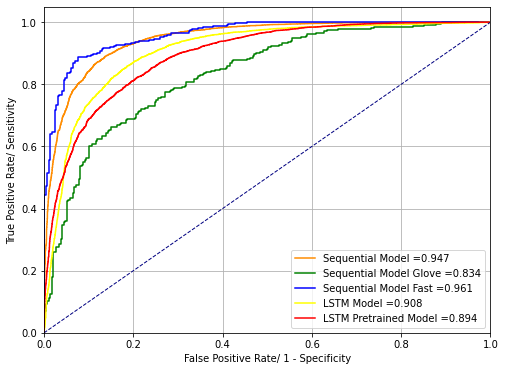

time: 211 ms (started: 2020-12-31 23:28:26 +00:00)


In [ ]:
# Comparar los resultados obtenidos
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc


plt.figure(figsize=(8, 6))
plt.grid()
# CBOW model
fpr, tpr, roc_auc = roc_curve_and_score(y_test, sequential_model_pred)
plt.plot(fpr, tpr, color='darkorange',
         label='Sequential Model ={0:.3f}'.format(roc_auc))
# Glove Model
fpr, tpr, roc_auc = roc_curve_and_score(y_test_glove, model_glove_pred)
plt.plot(fpr, tpr, color='green',
         label='Sequential Model Glove ={0:.3f}'.format(roc_auc))
# Fasttext Model
fpr, tpr, roc_auc = roc_curve_and_score(y_test_fast, model_fast_pred)
plt.plot(fpr, tpr, color='blue',
         label='Sequential Model Fast ={0:.3f}'.format(roc_auc))
# LSTM Model - trainable = True
fpr, tpr, roc_auc = roc_curve_and_score(y_test_lstm, lstm_pred)
plt.plot(fpr, tpr, color='yellow',
         label='LSTM Model ={0:.3f}'.format(roc_auc))
# LSTM Model - Pretrained Glove
fpr, tpr, roc_auc = roc_curve_and_score(y_test_lstm_pre, lstm_pretrained_pred)
plt.plot(fpr, tpr, color='red',
         label='LSTM Pretrained Model ={0:.3f}'.format(roc_auc))
# BERT 
#fpr, tpr, roc_auc = roc_curve_and_score(validation_data, np.array(model_bert_pred.values()))
#plt.plot(fpr, tpr, color='red',
#         label='BERT Model ={0:.3f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate/ 1 - Specificity')
plt.ylabel('True Positive Rate/ Sensitivity')
plt.show()

Descripción de los modelos:
* **Sequential Model**: modelo CBOW con tamaño de ventana 2 (Word2Vec), entrenado sobre la totalidad del vocabulario luego del preprocesamiento indicado por el TP. Se utilizó el promedio de los embeddings generado para cada oración (EMB_NUM = 300).
* **Sequential Model Glove**: modelo basado en los embedding preentrenados de Glove. Se utilizaron 3000 ejemplos (train + validation), calculando el promedio de los embeddings de las palabras presentes en Glove (EMB_NUM = 25).
* **Sequential Model Fast**: modelo basado en los embedding preentrenados de FastText. Se utilizaron 3000 ejemplos (train + validation), calculando el promedio de los embeddings de las palabras presentes en FastText (EMB_NUM = 300).
* **LSTM Model**: modelo LSTM con capa de Embeddings, pesos entrenables y longitud máxima de ejemplos de 80 (se probó llevando el padding al máximo valor dado por el ejemplo con más palabras, pero el resultado no era bueno - muchos 0).
* **LSTM Pretrained Model**: modelo LSTM con capa de Embeddings, pesos no entrenables (se utilizaron los embeddings preentrenados de Glove) y longitud máxima de ejemplos de 80. 